In [13]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

plt.style.use('themes/rose-pine-moon.mplstyle')


%config InlineBackend.figure_format='svg'

In [2]:
# Load all the data
data_runs = pd.read_csv('data/v1/runs-data.csv')
data_games = pd.read_csv('data/v1/games-data.csv')
data_categories = pd.read_csv('data/v1/categories-data.csv')
data_leaderboards = pd.read_csv('data/v1/leaderboards-data.csv')
data_levels = pd.read_csv('data/v1/levels-data.csv')
data_users = pd.read_csv('data/v1/users-data.csv')
data_platforms = pd.read_csv('data/other_dataset_with_platforms.csv')



In [3]:
# Only keep id and plateform for data_platforms
data_platforms = data_platforms[["platform_id","platform_name"]]
# Remove duplicates
data_platforms = data_platforms.drop_duplicates()

In [4]:
# Merge all the datasets
data = data_runs.merge(data_games, left_on='gameID', right_on='ID', how='left', suffixes=('', '_game'))
data = data.merge(data_categories, left_on='categoryID', right_on='ID', how='left', suffixes=('', '_category'))
data = data.merge(data_levels, left_on='levelID', right_on='ID', how='left', suffixes=('', '_level'))
data = data.merge(data_users, left_on='players', right_on='ID', how='left', suffixes=('', '_user'))
data = data.merge(data_leaderboards, left_on='ID', right_on='runID', how='left', suffixes=('', '_leaderboard'))
data = data.merge(data_platforms, left_on='platform', right_on='platform_id', how='left', suffixes=('', '_plateform'))



In [5]:
# Delete the arrays to free up memory
del data_runs
del data_games
del data_categories
del data_leaderboards
del data_levels
del data_users
del data_platforms


In [6]:
# Only keep verified runs
data = data[data['status'] == 'verified']

In [7]:
# Delete all columns if _id or ID in the name
data = data[[col for col in data.columns if '_id' not in col and 'ID' not in col]] 

In [8]:
# Delete the other columns that are not needed
data = data.drop(
    columns=[
        "platform",
        "players",
        "examiner",
        "values",
        "status",
        "statusReason",
        "verifiedDate",
        "URL",
        "createdDate",
        "numCategories",
        "numLevels",
        "rules",
        "type",
        "numPlayers",
        "name_level",
        "rules_level",
        "signupDate",
        "platform_leaderboard",
        "emulated_leaderboard",
        "players_leaderboard",
        "examiner_leaderboard",
        "verifiedDate_leaderboard",
        "variablesAndValues",
    ]
)

In [9]:
# Remove the rows with NaN values
data = data.dropna()

In [10]:
data.head()

,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location,numRuns,date_leaderboard,primaryTime_leaderboard,place,platform_name
1,2021-12-25,17.550,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,17.550,40.0,Web
2,2021-12-25,7.573,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,7.573,12.0,Web
3,2021-12-22,12.420,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,12.420,394.0,Web
6,2021-12-22,8.640,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,8.640,8.0,Web
8,2021-12-22,449.533,False,RE:RUN,2020-08-08,Any%,quebecpower,ca/qc,8.0,2021-12-22,449.533,239.0,PC


In [11]:
# Find the games ("name") with the most submissions, and keep the top 100, along with their release date and platform
top_games = data[["name", "name_category"]].value_counts()

# Same for time on leaderboard in 2023
data_2023 = data[data["date_leaderboard"] >= '2023-01-01']
top_games_2023 = data_2023[["name", "name_category"]].value_counts()

# Convert the index to columns
top_games = top_games.reset_index()
top_games_2023 = top_games_2023.reset_index()

# For each game, find the first release date and platform
top_games_data = data[data["name"].isin(top_games["name"])].groupby(["name", "name_category"]).agg(
    {"releaseDate": "first", "platform_name": "first"}
)
top_games_data_2023 = data_2023[data_2023["name"].isin(top_games_2023["name"])].groupby(["name", "name_category"]).agg(
    {"releaseDate": "first", "platform_name": "first"}
)



# Add count of submissions for each game and category in the top games
top_games_data = top_games_data.join(data[["name", "name_category"]].value_counts(), on=["name", "name_category"])

# Same for 2023
top_games_data_2023 = top_games_data_2023.join(data_2023[["name", "name_category"]].value_counts(), on=["name", "name_category"])

# Add sum of all submissions for each game in the top games
top_games_data["sum_count"] = top_games_data["count"].groupby("name").transform("sum")

# Same for 2023
top_games_data_2023["sum_count"] = top_games_data_2023["count"].groupby("name").transform("sum")

# Only keep the top 3 count of submissions for each game...
# First sort by count of submissions (descending) for each game
top_games_data = top_games_data.sort_values("count", ascending=False)
top_games_data_2023 = top_games_data_2023.sort_values("count", ascending=False)
# ... then keep the top 3 for each game
#top_games_data = top_games_data.groupby("name").head(3)

# Sort by count of submissions (descending)
top_games_data = top_games_data.sort_values(["sum_count", "count"], ascending=False)
top_games_data_2023 = top_games_data_2023.sort_values(["sum_count", "count"], ascending=False)
# Reset the index
#top_games_data = top_games_data.reset_index()

# # For each game, merge the three rows (each corresponding to a different category) into one row containig all the information (release date, platform, category,, and count of submissions for each category, and the sum of all submissions)
# top_games_data = top_games_data.groupby("name").agg(
#     {
#         "releaseDate": "first",
#         "platform_name": "first",
#         "name_category": lambda x: ", ".join(x),
#         "count": lambda x: ", ".join(x.astype(str)),
#         "sum_count": "first",
#     }
# )

# # Split the category and count of submissions into three columns
# top_games_data[["category1", "category2", "category3"]] = top_games_data["name_category"].str.split(", ", expand=True)
# top_games_data[["count1", "count2", "count3"]] = top_games_data["count"].str.split(", ", expand=True)

# # Remove the columns that are not needed
# top_games_data = top_games_data.drop(columns=["name_category", "count"])

# # Sort by sum of all submissions (descending)
# top_games_data = top_games_data.sort_values("sum_count", ascending=False)

# Remove any rown that have NaN or None
top_games_data = top_games_data.dropna()
top_games_data_2023 = top_games_data_2023.dropna()

# Reset the index
top_games_data = top_games_data.reset_index()
top_games_data_2023 = top_games_data_2023.reset_index()

# Keep the 100 unique games (name) with the most submissions, disregarding the category
top_games_data_names = top_games_data.drop_duplicates(subset=["name"]).head(100)

# Only keep the games that are in the top 100 games with the most submissions
top_games_data = top_games_data[top_games_data["name"].isin(top_games_data_names["name"])]
top_games_data_2023 = top_games_data_2023[top_games_data_2023["name"].isin(top_games_data_names["name"])]

# Only keep games that have had submission in 2023
top_games_data = top_games_data[top_games_data["name"].isin(top_games_data_2023["name"])]

# Merge the data from 2023 with the data from all the years
top_games_data = top_games_data.merge(top_games_data_2023, on=["name", "name_category", "releaseDate", "platform_name"] , how="left", suffixes=('', '_2023'))

# Fill NaN values with 0
top_games_data = top_games_data.fillna(0)

top_games_data

,name,name_category,releaseDate,platform_name,count,sum_count,count_2023,sum_count_2023
0,Seterra (Old Version),Pin,1997-01-01,Web,13657,40623,963.0,2954.0
1,Seterra (Old Version),Pin Hard,1997-01-01,Web,5745,40623,227.0,2954.0
2,Seterra (Old Version),Place the Labels,1997-01-01,Web,5106,40623,170.0,2954.0
3,Seterra (Old Version),Type,1997-01-01,Web,4624,40623,185.0,2954.0
4,Seterra (Old Version),Europe: Countries,1997-01-01,Web,1721,40623,194.0,2954.0
...,...,...,...,...,...,...,...,...
1446,Metroid Dread,100%,2021-10-08,Switch,96,1610,18.0,182.0
1447,Metroid Dread,Legacy,2021-10-08,Switch,78,1610,2.0,182.0
1448,Metroid Dread,0%,2021-10-08,Switch,26,1610,7.0,182.0
1449,Metroid Dread,Minimum Items (Obsoleted),2021-10-08,Switch,7,1610,1.0,182.0


In [49]:
# Only keep the data for the top 100 games
data_top_100 = data[data["name"].isin(top_games_data["name"])]
data_2023_top_100 = data_2023[data_2023["name"].isin(top_games_data["name"])]

# Drop platform_name for this analysis
data_top_100 = data_top_100.drop(columns=["platform_name"])
data_2023_top_100 = data_2023_top_100.drop(columns=["platform_name"])

# For each game and each category, get distribution of primaryTime_leaderboard (bins and counts for each bin)
data_distribution = data_top_100.groupby(["name", "name_category"])["primaryTime_leaderboard"]
data_distribution_2023 = data_2023_top_100.groupby(["name", "name_category"])["primaryTime_leaderboard"]

data_distribution = {x: np.histogram(dist) for x, dist in data_distribution}
data_distribution_2023 = {x: np.histogram(data_distribution_2023.get_group(x), hist[1]) if x in data_distribution_2023.groups else np.histogram([np.nan], hist[1]) for x, hist in data_distribution.items()}


# Merge the data from 2023 with the data from all the years
data_distribution = {x: {'count_all':data_distribution[x][0], 'count_2023':data_distribution_2023[x][0], 'bins': data_distribution[x][1]} for x in data_distribution}


In [50]:
data_distribution

{('A Hat in Time',
  '110%'): {'count_all': array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1]), 'count_2023': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 'bins': array([12612.27 , 15271.665, 17931.06 , 20590.455, 23249.85 , 25909.245,
         28568.64 , 31228.035, 33887.43 , 36546.825, 39206.22 ])},
 ('A Hat in Time',
  '2 Character'): {'count_all': array([13,  5,  3,  3,  4,  2,  2,  0,  1,  2]), 'count_2023': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'bins': array([  9.01 ,  45.055,  81.1  , 117.145, 153.19 , 189.235, 225.28 ,
         261.325, 297.37 , 333.415, 369.46 ])},
 ('A Hat in Time',
  'All Time Pieces'): {'count_all': array([18, 20, 18, 10,  6,  1,  0,  0,  0,  1]), 'count_2023': array([5, 1, 1, 1, 0, 0, 0, 0, 0, 0]), 'bins': array([ 4180.57 ,  5144.602,  6108.634,  7072.666,  8036.698,  9000.73 ,
          9964.762, 10928.794, 11892.826, 12856.858, 13820.89 ])},
 ('A Hat in Time',
  'Any%'): {'count_all': array([1008,  407,  159,   23,    8,    2,    0,    2,    0,    1]), 'count_2023': array

In [16]:
data_top_100

,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location,numRuns,date_leaderboard,primaryTime_leaderboard,place,percentile
1,2021-12-25,17.550,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,17.550,40.0,20%_40%
2,2021-12-25,7.573,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,7.573,12.0,min_20%
3,2021-12-22,12.420,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,12.420,394.0,20%_40%
6,2021-12-22,8.640,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,8.640,8.0,min_20%
29,2021-05-23,696.000,False,Super Mario Odyssey Category Extensions,2017-10-27,Nipple%,Pandox_07,gb/eng,2.0,2021-05-23,696.000,779.0,60%_80%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995665,2021-05-21,105.000,False,Hitman 3 Category Extensions,2021-01-20,Sniper (ballistic),NatholDallas,cn,7.0,2021-05-21,105.000,9.0,60%_80%
3995667,2023-10-12,194.000,False,ROBLOX: Piggy,2020-01-23,Chapter 1: House,makr707,sa,1.0,2023-10-12,194.000,844.0,60%_80%
3995671,2016-08-24,302.269,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se,25.0,2016-08-24,302.269,456.0,20%_40%
3995702,2021-07-28,233.233,False,ROBLOX: Speed Run 4,2013-01-01,No Skips,ElLachoMaster,mx,1.0,2021-07-28,233.233,4662.0,80%_max


In [ ]:
# Get the data for barplot 1
barplot_1 = top_games_data.groupby("name").agg({"count": "sum"}).sort_values("count", ascending=False).reset_index()

# Add a column with the string "game" to barplot_1
barplot_1["identifier"] = "game"

# Add a column with the name of the game without spaces or parentheses concatenated with the string "type_submission" t barplot_1
barplot_1["name_type"] = barplot_1["name"].str.replace(" ", "").str.replace("(", "").str.replace(")", "") + "_type_submission"

barplot_1


,name,count,identifier,name_type
0,Seterra (Old Version),40623,game,SeterraOldVersion_type_submission
1,Speed Builders,12784,game,SpeedBuilders_type_submission
2,Super Mario 64,9970,game,SuperMario64_type_submission
3,Google Snake,8334,game,GoogleSnake_type_submission
4,ROBLOX: Arsenal,8140,game,ROBLOX:Arsenal_type_submission
...,...,...,...,...
95,FlatOut 2,1623,game,FlatOut2_type_submission
96,Google Minesweeper,1621,game,GoogleMinesweeper_type_submission
97,Refunct,1614,game,Refunct_type_submission
98,Spelunky 2,1611,game,Spelunky2_type_submission


In [ ]:
# Get the data for barplot 2, corresponding to the list of submissions per submission type per game
barplot_2 = top_games_data.groupby(["name", "name_category"]).agg({"count": "sum"}).reset_index()

# Add a column with the name of the game without spaces or parentheses concatenated with the string "type_submission" to barplot_2
barplot_2["name_type"] = barplot_2["name"].str.replace(" ", "").str.replace("(", "").str.replace(")", "") + "_type_submission"

# Add a column with the name "quantiles_" concatenated with barplot_2["name_type"]
barplot_2["name_category"] = "dist_" + barplot_2["name"].str.replace(" ", "").str.replace("(", "").str.replace(")", "") +'_' + barplot_2['name_category']

# Transform name into a multiindex
#barplot_2 = barplot_2.set_index(["name"])

barplot_2 = {name:group for name, group in barplot_2.groupby('name')}   

barplot_2

{'A Hat in Time':             name                         name_category  count  \
 0  A Hat in Time             quantiles_AHatinTime_110%      5   
 1  A Hat in Time      quantiles_AHatinTime_2 Character     35   
 2  A Hat in Time  quantiles_AHatinTime_All Time Pieces     74   
 3  A Hat in Time             quantiles_AHatinTime_Any%   1610   
 4  A Hat in Time     quantiles_AHatinTime_Console Runs     61   
 5  A Hat in Time       quantiles_AHatinTime_Death Wish     10   
 6  A Hat in Time       quantiles_AHatinTime_Restricted    524   
 
                     name_type  
 0  AHatinTime_type_submission  
 1  AHatinTime_type_submission  
 2  AHatinTime_type_submission  
 3  AHatinTime_type_submission  
 4  AHatinTime_type_submission  
 5  AHatinTime_type_submission  
 6  AHatinTime_type_submission  ,
 'Bhop pro':         name                               name_category  count  \
 7   Bhop pro           quantiles_Bhoppro_Any% Glitchless     12   
 8   Bhop pro                    quantil

In [51]:
# Get the data for barplot_3, corresponding to the quantiles of run times for each category of each game
barplot_3 = data_distribution

barplot_3

{('A Hat in Time',
  '110%'): {'count_all': array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1]), 'count_2023': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 'bins': array([12612.27 , 15271.665, 17931.06 , 20590.455, 23249.85 , 25909.245,
         28568.64 , 31228.035, 33887.43 , 36546.825, 39206.22 ])},
 ('A Hat in Time',
  '2 Character'): {'count_all': array([13,  5,  3,  3,  4,  2,  2,  0,  1,  2]), 'count_2023': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'bins': array([  9.01 ,  45.055,  81.1  , 117.145, 153.19 , 189.235, 225.28 ,
         261.325, 297.37 , 333.415, 369.46 ])},
 ('A Hat in Time',
  'All Time Pieces'): {'count_all': array([18, 20, 18, 10,  6,  1,  0,  0,  0,  1]), 'count_2023': array([5, 1, 1, 1, 0, 0, 0, 0, 0, 0]), 'bins': array([ 4180.57 ,  5144.602,  6108.634,  7072.666,  8036.698,  9000.73 ,
          9964.762, 10928.794, 11892.826, 12856.858, 13820.89 ])},
 ('A Hat in Time',
  'Any%'): {'count_all': array([1008,  407,  159,   23,    8,    2,    0,    2,    0,    1]), 'count_2023': array

In [56]:
# Get the data for the scatterplots, corresponding to the distribution of run times for bin for each category of each game
scatterplot = {}
for (game, category) in barplot_3:
    bins = barplot_3[(game, category)]['bins']
    array_run = data_top_100[(data_top_100['name'] == game) & (data_top_100['name_category'] == category)]
    array_run_2023 = data_2023_top_100[(data_2023_top_100['name'] == game) & (data_2023_top_100['name_category'] == category)]
    for b1, b2 in zip(bins[:-1], bins[1:]):
        array_run_b = array_run[(array_run['primaryTime_leaderboard'] >= b1) & (array_run['primaryTime_leaderboard'] < b2) & (array_run['date'] < '2023-01-01')]
        array_run_2023_b = array_run_2023[(array_run_2023['primaryTime_leaderboard'] >= b1) & (array_run_2023['primaryTime_leaderboard'] < b2)]
        if len(array_run_b)>0:
            scatterplot[(game, category, b1, 'all')] = array_run_b
        if len(array_run_2023_b)>0:
            scatterplot[(game, category, b1, 2023)] = array_run_2023_b

In [57]:
scatterplot

{('A Hat in Time',
  '110%',
  12612.27,
  2023):                date  primaryTime  emulated           name releaseDate  \
 1140071  2023-02-08     12612.27     False  A Hat in Time  2017-10-05   
 
         name_category name_user location  numRuns date_leaderboard  \
 1140071          110%      enhu       ar    127.0       2023-02-08   
 
          primaryTime_leaderboard  place  
 1140071                 12612.27    1.0  ,
 ('A Hat in Time',
  '110%',
  15271.665,
  'all'):                date  primaryTime  emulated           name releaseDate  \
 1249347  2020-12-27     16137.77     False  A Hat in Time  2017-10-05   
 
         name_category name_user location  numRuns date_leaderboard  \
 1249347          110%  Alberona       se    246.0       2020-12-27   
 
          primaryTime_leaderboard  place  
 1249347                 16137.77    2.0  ,
 ('A Hat in Time',
  '110%',
  25909.245000000003,
  2023):               date  primaryTime  emulated           name releaseDate  \
 46600

In [52]:
data_top_100

,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location,numRuns,date_leaderboard,primaryTime_leaderboard,place
1,2021-12-25,17.550,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,17.550,40.0
2,2021-12-25,7.573,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-25,7.573,12.0
3,2021-12-22,12.420,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,12.420,394.0
6,2021-12-22,8.640,False,Google Snake,2017-09-27,25 Apples,quebecpower,ca/qc,8.0,2021-12-22,8.640,8.0
29,2021-05-23,696.000,False,Super Mario Odyssey Category Extensions,2017-10-27,Nipple%,Pandox_07,gb/eng,2.0,2021-05-23,696.000,779.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995665,2021-05-21,105.000,False,Hitman 3 Category Extensions,2021-01-20,Sniper (ballistic),NatholDallas,cn,7.0,2021-05-21,105.000,9.0
3995667,2023-10-12,194.000,False,ROBLOX: Piggy,2020-01-23,Chapter 1: House,makr707,sa,1.0,2023-10-12,194.000,844.0
3995671,2016-08-24,302.269,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se,25.0,2016-08-24,302.269,456.0
3995702,2021-07-28,233.233,False,ROBLOX: Speed Run 4,2013-01-01,No Skips,ElLachoMaster,mx,1.0,2021-07-28,233.233,4662.0


In [13]:
# Save the data as json
top_games_data.to_json("output/top_games_data.json", orient="records")

In [ ]:
# Only keep 'super mario bros. 3' data
data = data[data['name'] == 'Super Mario Bros. 3']

# Only keep Any% data
data = data[data['name_category'] == 'Any%']

In [ ]:
# Sort by primaryTime
data = data.sort_values(by='primaryTime')

In [ ]:
# Remove name_user which only have 1 run
data = data.groupby('name_user').filter(lambda x: len(x) > 1)

In [ ]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])


/var/folders/l8/7h5sfbjn2ng3kg7y8p21r8qr0000gn/T/ipykernel_59213/512597834.py:3: UserWarning: 
The palette list has fewer values (1) than needed (241) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=data, x="date", y="primaryTime", hue="name_user", alpha=0.2, marker='.', palette=['C1'], markerfacecolor='C1', markersize=4, markeredgewidth=0, linewidth=0.5)
/var/folders/l8/7h5sfbjn2ng3kg7y8p21r8qr0000gn/T/ipykernel_59213/512597834.py:9: UserWarning: 
The palette list has fewer values (1) than needed (241) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=best_time, x="date", y="primaryTime", hue="name_user", alpha=1, marker='.', palette=['C2'], markerfacecolor='C2', markersize=4, markeredgewidth=0, linewidth=0.5)


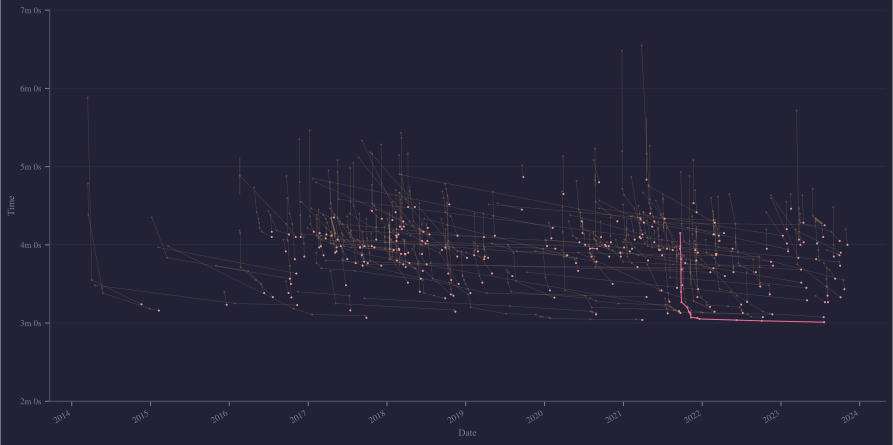

In [ ]:
# do a lineplot with markers
plt.figure(figsize=(15,8))
sns.lineplot(data=data, x="date", y="primaryTime", hue="name_user", alpha=0.2, marker='.', palette=['C1'], markerfacecolor='C1', markersize=4, markeredgewidth=0, linewidth=0.5)

# Add a lineplot highlighted for the best time
best_time = data.groupby('name_user')['primaryTime'].min()
best_time = best_time.reset_index()
best_time = best_time.merge(data, on=['name_user', 'primaryTime'])
sns.lineplot(data=best_time, x="date", y="primaryTime", hue="name_user", alpha=1, marker='.', palette=['C2'], markerfacecolor='C2', markersize=4, markeredgewidth=0, linewidth=0.5)

# Highlight the whole history of the user with the best absolute time
best_time = best_time.sort_values(by='primaryTime')
best_time = best_time.iloc[0]
sns.lineplot(data=data[data['name_user'] == best_time['name_user']], x="date", y="primaryTime", hue="name_user", alpha=1, marker='.', palette=['C6'], markerfacecolor='C6', markersize=4, markeredgewidth=0, linewidth=1)

# Convert the x-axis labels to dates
plt.gcf().autofmt_xdate()

# Convert the y-axis labels minutes and seconds (range from 2mn to 8mn)
plt.yticks(range(120, 480, 60), [f"{i//60}m {i%60}s" for i in range(120, 480, 60)])

# Remove legend
plt.legend([],[], frameon=False)

# Set the x-axis label
plt.xlabel("Date")

# Set the y-axis label
plt.ylabel("Time")

#plt.show()
plt.savefig('output/plot.svg', format='svg')
